# Exploring Dandiset 001375: Septum GABA disruption with DREADDs

## ⚠️ AI-Generated Notebook Disclaimer

**This notebook was created by an AI assistant and has not been fully verified.** 
The code and analyses provided here are intended as a starting point for exploration.
Please review all code carefully and be cautious when interpreting the results.

## Introduction

This notebook explores the data from Dandiset 001375, which can be found at [https://dandiarchive.org/dandiset/001375](https://dandiarchive.org/dandiset/001375).

This dataset contains neural recordings from mice with DREADDs (Designer Receptors Exclusively Activated by Designer Drugs) targeting GABAergic neurons in the medial septum. The recordings were taken while the mice were running laps in a virtual hallway environment. The goal of the study was to examine how disrupting septal GABAergic activity affects neural activity in the hippocampus and neocortex.

## Overview of the Notebook

This notebook will cover:

1. Loading and exploring metadata from the Dandiset
2. Examining the dataset structure and contents
3. Loading and visualizing neural recordings from the NWB files
4. Analyzing spike train data and neural responses in relation to behavioral trials
5. Visualizing raw neural data and spectral properties
6. Exploring the relationship between neural activity and behavior

## Required Packages

The following packages are needed to run this notebook:

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up visualization style
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 8)

## Loading the Dandiset

In [2]:
# Connect to DANDI archive
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001375")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

# List the assets in the Dandiset
assets = list(dandiset.get_assets())
print(f"\nFound {len(assets)} assets in the dataset")
print("\nFirst 5 assets:")
for asset in assets[:5]:
    print(f"- {asset.path}")

Dandiset name: Septum GABA disruption with DREADDs
Dandiset URL: https://dandiarchive.org/dandiset/001375/0.250406.1855

Found 3 assets in the dataset

First 5 assets:
- sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb


## Exploring the Dataset Contents

Let's examine what files are available in this dataset. The dataset contains NWB (Neurodata Without Borders) files with neural recordings from mice during behavioral experiments.

In [3]:
# Display more details about the assets
asset_info = []
for asset in assets:
    size_mb = asset.size / (1024 * 1024)  # Convert to MB
    asset_info.append({
        'path': asset.path,
        'size_mb': size_mb,
        'id': asset.identifier
    })

# Create a DataFrame for better display
assets_df = pd.DataFrame(asset_info)
assets_df

,path,size_mb,id
0,sub-MS13B/sub-MS13B_ses-20240725T190000_ecephy...,52424.188275,ce525828-8534-4b56-9e47-d2a34d1aa897
1,sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12...,66228.544206,376dc673-611b-4521-b135-9ec01c7f4f74
2,sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ar...,66555.863855,fea95c0e-2f07-49a3-b607-4b7e9f278e16


### Understanding the Dataset Structure

The dataset contains recordings from two subjects:
1. **MS13B** - One recording session
2. **MS14A** - Two recording sessions with different recording locations

These recordings were made while the mice were running laps in a virtual hallway. The recordings include spikes from individual neurons as well as raw electrophysiology data from silicon probes.

## Loading and Exploring an NWB File

Let's load one of the NWB files and explore its contents. We'll start with the first file from subject MS13B.

In [4]:
# Load the first NWB file
asset_id = "ce525828-8534-4b56-9e47-d2a34d1aa897"  # MS13B
url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the session
print(f"Session ID: {nwb.identifier}")
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"File creation date: {nwb.file_create_date}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session ID: MS13B
Session description: mouse running laps in virtual hallway
Session start time: 2024-07-25 19:00:00-07:00
File creation date: [datetime.datetime(2025, 4, 5, 16, 50, 15, 663983, tzinfo=tzoffset(None, -25200))]


### Subject Information

In [5]:
# Print information about the subject
subject = nwb.subject
print(f"Subject ID: {subject.subject_id}")
print(f"Age: {subject.age}")
print(f"Sex: {subject.sex}")
print(f"Species: {subject.species}")
print(f"Description: {subject.description}")

Subject ID: MS13B
Age: P90D
Sex: M
Species: Mus musculus
Description: medial septum DREADD to suppress GABA interneurons


### Electrode Information

The recordings were made using silicon probe arrays with multiple electrodes arranged in "shanks". Let's explore the electrode setup.

In [6]:
# Get electrode information
electrodes_df = nwb.electrodes.to_dataframe()
print(f"Total number of electrodes: {len(electrodes_df)}")

# Show info about electrode groups
for group_name, group in nwb.electrode_groups.items():
    print(f"\nGroup: {group_name}")
    print(f"  Description: {group.description}")
    print(f"  Location: {group.location}")
    print(f"  Device: {group.device.description} ({group.device.manufacturer})")

# Display a sample of the electrodes dataframe
electrodes_df.head()

Total number of electrodes: 256

Group: shank1
  Description: shank1, electrodes
  Location: ventral hippocampus, visual cortex
  Device: 128 ch silicon probe (UCLA)

Group: shank2
  Description: shank2, electrodes
  Location: ventral hippocampus, visual cortex
  Device: 128 ch silicon probe (UCLA)


,x,y,location,filtering,group,group_name,label
id,,,,,,,
0,20.0,1375.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13976...,shank1,shank1-electrode001
1,20.0,1325.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13976...,shank1,shank1-electrode002
2,20.0,1275.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13976...,shank1,shank1-electrode003
3,20.0,1225.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13976...,shank1,shank1-electrode004
4,20.0,1175.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13976...,shank1,shank1-electrode005


Let's visualize the electrode positions to better understand the recording configuration:

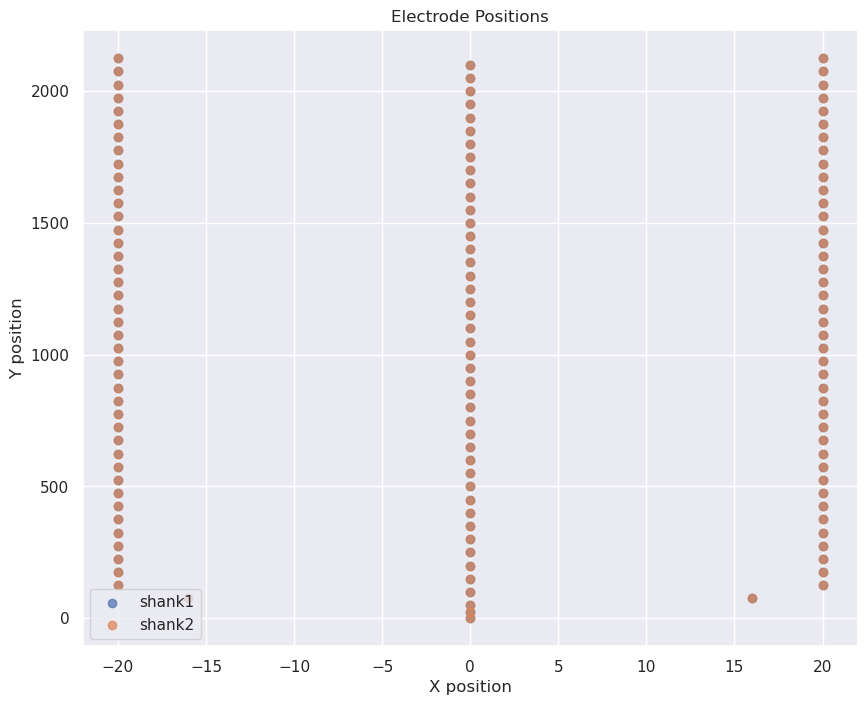

In [7]:
# Plot electrode positions
plt.figure(figsize=(10, 8))
for group_name, group_df in electrodes_df.groupby('group_name'):
    plt.scatter(group_df['x'], group_df['y'], label=group_name, alpha=0.7)

plt.title('Electrode Positions')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.grid(True)

The electrode positions show that the recording electrodes are arranged in multiple vertical columns (shanks). These electrodes are used to record from different layers of the brain.

### Exploring Neural Units (Neurons)

The dataset contains spike times for individual neurons (units). Let's examine the neurons and their properties.

Total number of units: 33
Available columns: ['spike_times']

Firing rate statistics (Hz):
count    33.000000
mean     13.374927
std      12.926557
min       1.734432
25%       4.823191
50%       8.312348
75%      18.015421
max      58.168861
dtype: float64


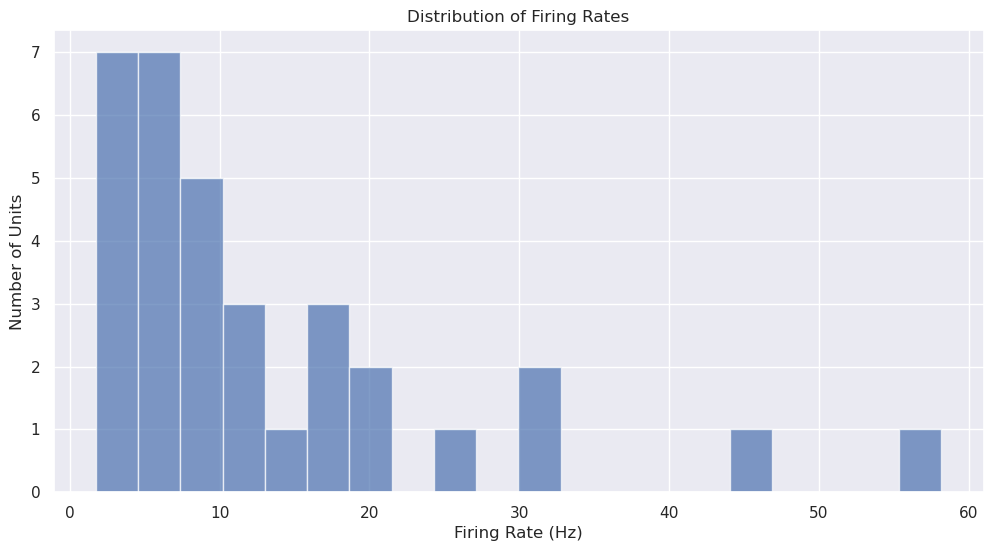

In [8]:
# Get information about neural units
units_df = nwb.units.to_dataframe()
print(f"Total number of units: {len(units_df)}")
print(f"Available columns: {units_df.columns.tolist()}")

# Calculate firing rates for all units
# Convert VectorData to numpy array before using max()
recording_duration = np.max(nwb.trials['stop_time'][:])  # Use the end of the last trial as recording duration
firing_rates = []

# Loop through all units and calculate firing rates
for i in range(len(units_df)):
    spike_times = nwb.units['spike_times'][i]
    firing_rate = len(spike_times) / recording_duration
    firing_rates.append(firing_rate)

# Add firing rates to the dataframe
units_df['firing_rate'] = firing_rates

# Display basic statistics about firing rates
print("\nFiring rate statistics (Hz):")
print(pd.Series(firing_rates).describe())

# Plot histogram of firing rates
plt.figure(figsize=(12, 6))
plt.hist(firing_rates, bins=20, alpha=0.7)
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Number of Units')
plt.title('Distribution of Firing Rates')
plt.grid(True)

The histogram shows that the firing rates of neurons have a bimodal distribution, with most neurons firing at lower rates (0-10 Hz) and a smaller group firing at higher rates (20-60 Hz). This is typical in extracellular recordings, where the lower-firing neurons are likely principal excitatory neurons, and the higher-firing neurons are likely inhibitory interneurons.

Now, let's visualize the firing patterns of a few neurons by creating a spike raster plot:

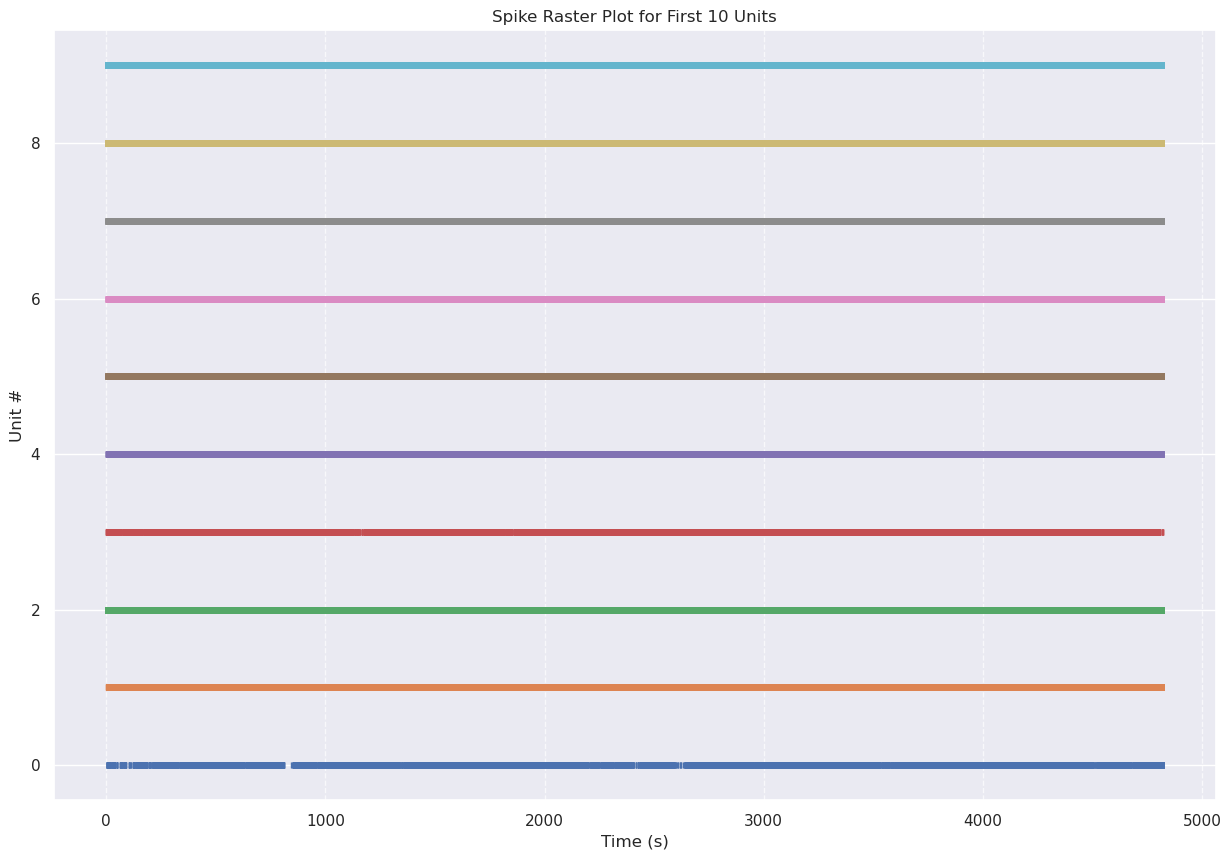

In [9]:
# Plot spike raster for a few units
plt.figure(figsize=(15, 10))
num_units_to_plot = min(10, len(units_df))

# Create the spike raster plot
for i in range(num_units_to_plot):
    spike_times = nwb.units['spike_times'][i]
    plt.plot(spike_times, np.ones_like(spike_times) * i, '|', markersize=4)
    
plt.xlabel('Time (s)')
plt.ylabel('Unit #')
plt.title(f'Spike Raster Plot for First {num_units_to_plot} Units')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

### Exploring Trial Information

The experiments were conducted with the mice running multiple trials/laps in a virtual hallway. Let's explore the trial structure:

Total number of trials: 387
Trial columns: ['start_time', 'stop_time']

Trial duration statistics (seconds):
count    387.000000
mean      12.300654
std        8.968260
min        7.656600
25%        9.964817
50%       10.857600
75%       12.095133
max      164.306967
Name: duration, dtype: float64


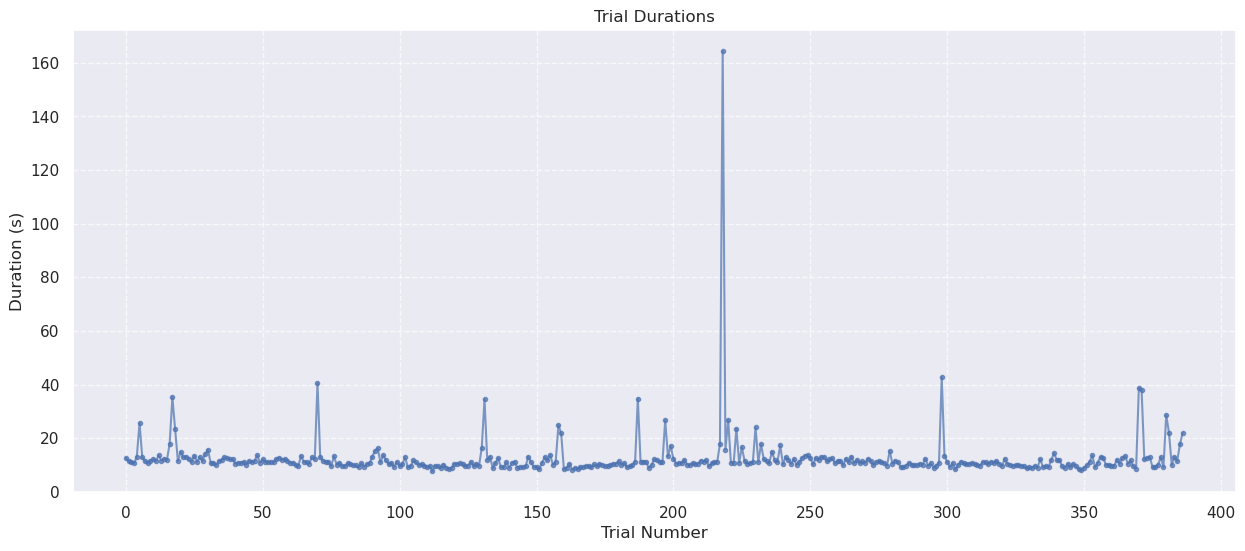

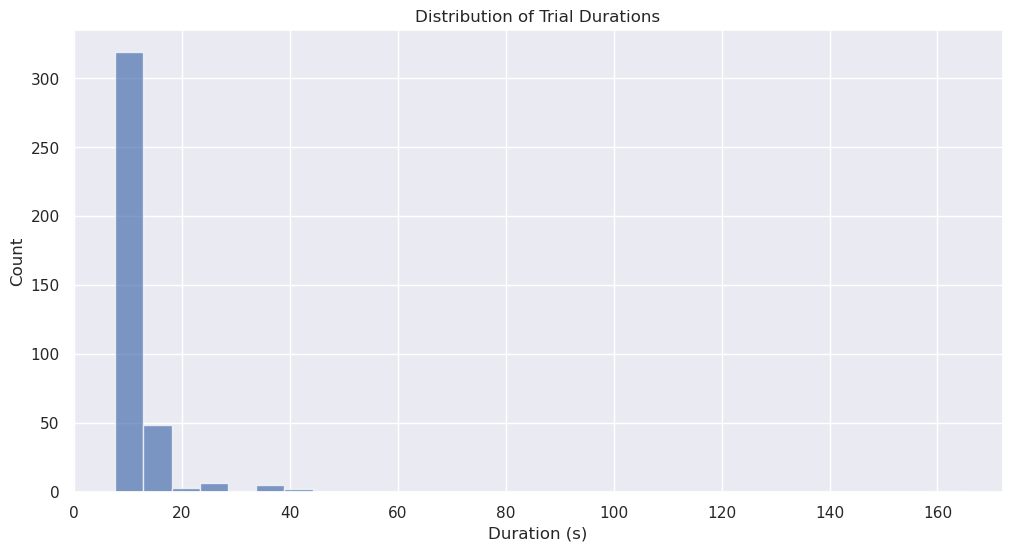

In [10]:
# Get trial information
trials_df = nwb.intervals['trials'].to_dataframe()
print(f"Total number of trials: {len(trials_df)}")
print(f"Trial columns: {trials_df.columns.tolist()}")

# Calculate trial durations
trials_df['duration'] = trials_df['stop_time'] - trials_df['start_time']

# Display summary statistics for trial durations
print("\nTrial duration statistics (seconds):")
print(trials_df['duration'].describe())

# Plot trial durations
plt.figure(figsize=(15, 6))
plt.plot(trials_df['duration'], marker='o', linestyle='-', markersize=3, alpha=0.7)
plt.title('Trial Durations')
plt.xlabel('Trial Number')
plt.ylabel('Duration (s)')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot histogram of trial durations
plt.figure(figsize=(12, 6))
plt.hist(trials_df['duration'], bins=30, alpha=0.7)
plt.title('Distribution of Trial Durations')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.grid(True)

The plots show that most trials last around 10 seconds, with some longer trials. This variability could reflect differences in the animal's behavior during the task.

### Neural Responses to Trial Events

Let's look at how neurons respond to trial events by plotting peri-stimulus time histograms (PSTHs) aligned to trial start:

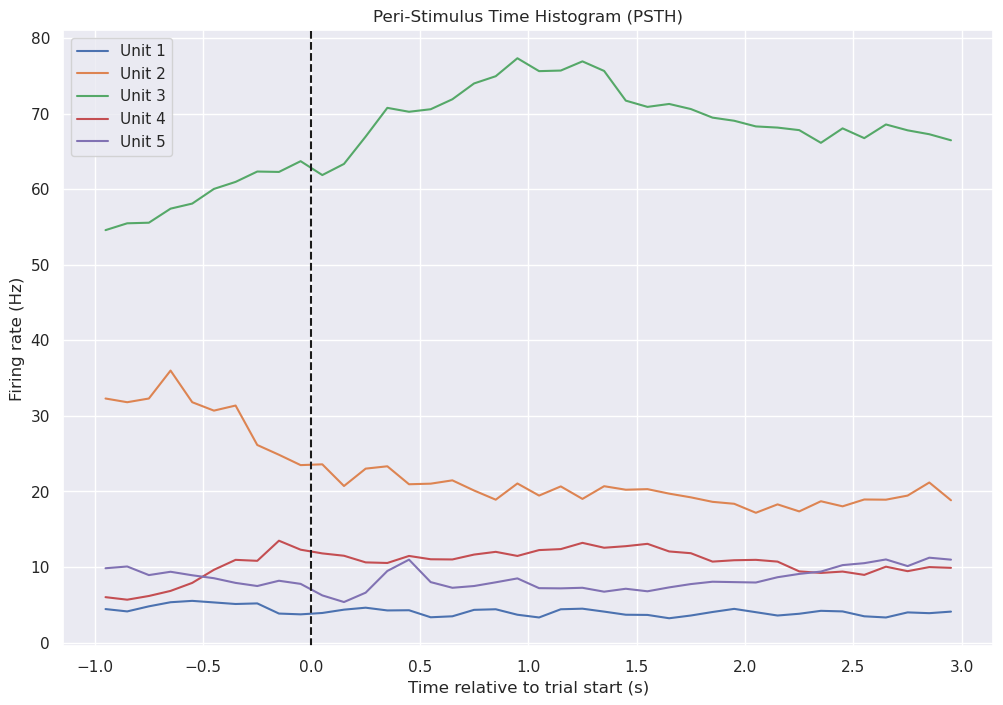

In [11]:
# Create PSTH aligned to trial start
trial_starts = trials_df['start_time'].values
window = [-1, 3]  # 1 second before to 3 seconds after trial start
bin_size = 0.1  # 100 ms bins
bins = np.arange(window[0], window[1] + bin_size, bin_size)
bin_centers = bins[:-1] + bin_size/2

# Choose a few units for PSTH analysis
units_for_psth = min(5, len(units_df))

plt.figure(figsize=(12, 8))
for i in range(units_for_psth):
    unit_id = units_df.index[i]
    spike_times = nwb.units['spike_times'][i]
    
    # Compute PSTH for this unit
    unit_psth = np.zeros(len(bins)-1)
    for t_start in trial_starts:
        # Align spikes to trial start
        aligned_spikes = spike_times - t_start
        # Count spikes in each bin
        hist, _ = np.histogram(aligned_spikes, bins=bins)
        unit_psth += hist
    
    # Normalize by number of trials and bin size to get firing rate
    unit_psth = unit_psth / (len(trial_starts) * bin_size)
    
    # Plot PSTH for this unit
    plt.plot(bin_centers, unit_psth, label=f'Unit {unit_id}')

plt.axvline(x=0, color='k', linestyle='--')  # Trial start
plt.xlabel('Time relative to trial start (s)')
plt.ylabel('Firing rate (Hz)')
plt.title('Peri-Stimulus Time Histogram (PSTH)')
plt.legend()
plt.grid(True)

The PSTH plot shows how different neurons respond to the start of trials. We can see various response patterns:
- Some neurons show increased firing after trial start
- Some show decreased firing
- Some show transient responses

These different response patterns suggest that the neurons have different functional roles in the task.

### Exploring Raw Neural Data

Now, let's examine the raw electrophysiology data. Given the large size of the dataset, we'll look at a small segment:

Raw data shape: (144675584, 256)
Sampling rate: 30000.0 Hz
Unit: mV


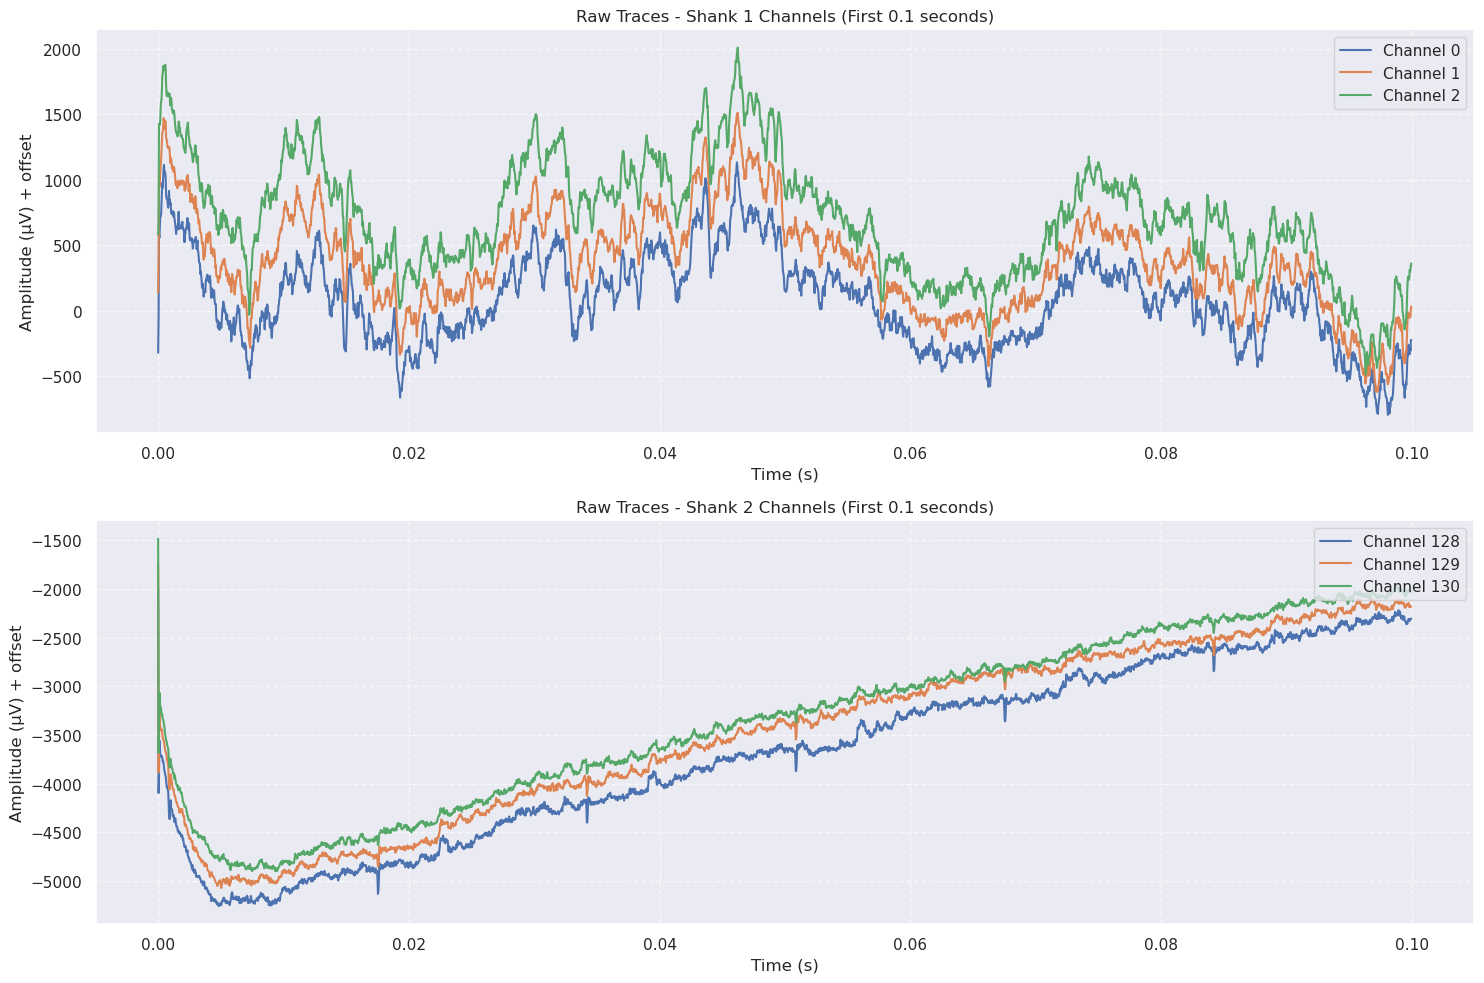

In [12]:
# Get information about the raw data
time_series = nwb.acquisition["time_series"]
print(f"Raw data shape: {time_series.data.shape}")
print(f"Sampling rate: {time_series.rate} Hz")
print(f"Unit: {time_series.unit}")

# Extract a short segment of raw data for visualization (first 0.1 seconds)
# Using a small number of samples and channels to avoid loading too much data
sampling_rate = time_series.rate
segment_duration = 0.1  # seconds
num_samples = int(segment_duration * sampling_rate)
num_channels_to_plot = 3  # plotting only a few channels

# Select a few channels from each shank
shank1_channels = electrodes_df[electrodes_df['group_name'] == 'shank1'].index[:num_channels_to_plot]
shank2_channels = electrodes_df[electrodes_df['group_name'] == 'shank2'].index[:num_channels_to_plot]

# Get raw data for selected channels
raw_data_shank1 = time_series.data[:num_samples, shank1_channels]
raw_data_shank2 = time_series.data[:num_samples, shank2_channels]

# Calculate time vector
time_vector = np.arange(num_samples) / sampling_rate

# Plot raw traces
plt.figure(figsize=(15, 10))

# Plot shank1 channels
plt.subplot(2, 1, 1)
for i in range(min(num_channels_to_plot, len(shank1_channels))):
    channel_id = shank1_channels[i]
    # Scale and offset the trace for better visualization
    offset = i * 200  # arbitrary offset to separate traces
    plt.plot(time_vector, raw_data_shank1[:, i] + offset, label=f"Channel {channel_id}")

plt.title(f"Raw Traces - Shank 1 Channels (First {segment_duration} seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV) + offset")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot shank2 channels
plt.subplot(2, 1, 2)
for i in range(min(num_channels_to_plot, len(shank2_channels))):
    channel_id = shank2_channels[i]
    # Scale and offset the trace for better visualization
    offset = i * 200  # arbitrary offset to separate traces
    plt.plot(time_vector, raw_data_shank2[:, i] + offset, label=f"Channel {channel_id}")

plt.title(f"Raw Traces - Shank 2 Channels (First {segment_duration} seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV) + offset")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

The raw traces show the electrophysiological activity recorded from multiple channels. You can see:
- Fast oscillations and potential action potentials
- Differences in signal amplitude and patterns between channels
- Potential artifacts in some channels

This high-resolution data allows for detailed analysis of neural activity.

## Comparing Recordings from Different Subjects and Sessions

Now let's load data from another NWB file to compare between subjects. We'll use one of the MS14A recordings.

In [13]:
# Load the second NWB file (MS14A - obj-12781w8)
asset_id_2 = "376dc673-611b-4521-b135-9ec01c7f4f74"
url_2 = f"https://api.dandiarchive.org/api/assets/{asset_id_2}/download/"
remote_file_2 = remfile.File(url_2)
h5_file_2 = h5py.File(remote_file_2)
io_2 = pynwb.NWBHDF5IO(file=h5_file_2)
nwb_2 = io_2.read()

# Get basic information
print(f"Subject ID: {nwb_2.subject.subject_id}")
print(f"Session description: {nwb_2.session_description}")
print(f"Number of electrodes: {len(nwb_2.electrodes)}")
print(f"Number of units: {len(nwb_2.units)}")
print(f"Number of trials: {len(nwb_2.trials)}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Subject ID: MS14A
Session description: mouse running laps in virtual hallway
Number of electrodes: 256
Number of units: 68
Number of trials: 716


Now let's compare the trial structure between the two subjects to see if there are any differences in the behavioral task:

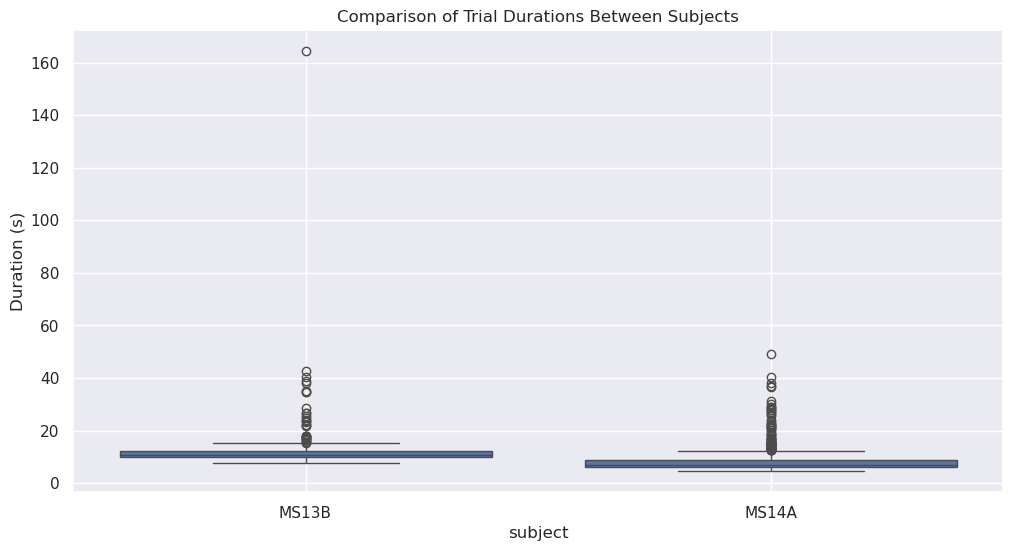

In [14]:
# Get trial information from both recordings
trials_1 = nwb.intervals['trials'].to_dataframe()
trials_1['duration'] = trials_1['stop_time'] - trials_1['start_time']
trials_1['subject'] = 'MS13B'

trials_2 = nwb_2.intervals['trials'].to_dataframe()
trials_2['duration'] = trials_2['stop_time'] - trials_2['start_time']
trials_2['subject'] = 'MS14A'

# Combine the data
combined_trials = pd.concat([trials_1, trials_2])

# Compare trial durations using box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='subject', y='duration', data=combined_trials)
plt.title('Comparison of Trial Durations Between Subjects')
plt.ylabel('Duration (s)')
plt.grid(True)

Let's also compare the neural activity by looking at the firing rate distributions for both subjects:

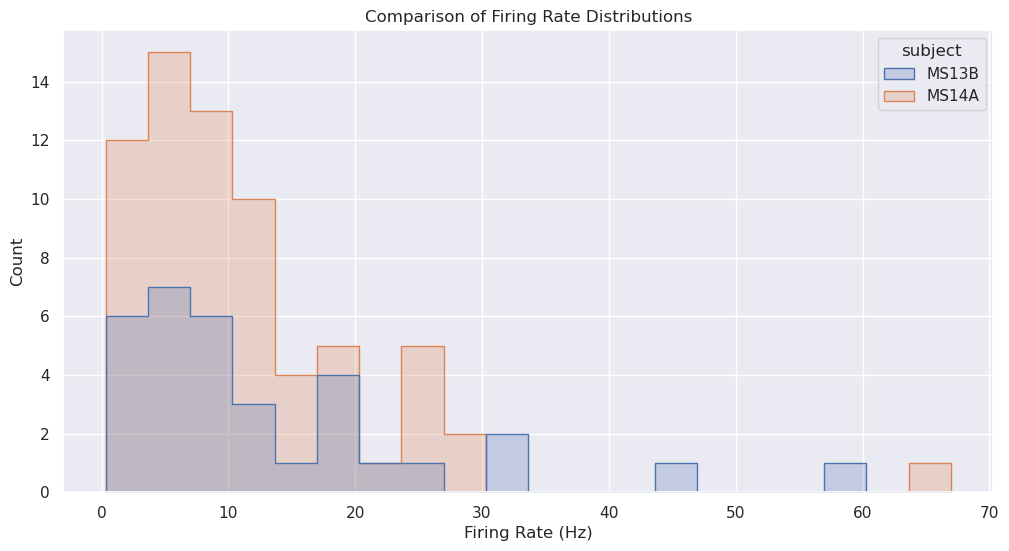

In [15]:
# Calculate firing rates for the second NWB file
# Convert VectorData to numpy array before using max()
recording_duration_2 = np.max(nwb_2.trials['stop_time'][:])
firing_rates_2 = []

for i in range(len(nwb_2.units)):
    spike_times = nwb_2.units['spike_times'][i]
    firing_rate = len(spike_times) / recording_duration_2
    firing_rates_2.append(firing_rate)

# Create a DataFrame for comparison
firing_rate_data = pd.DataFrame({
    'firing_rate': firing_rates + firing_rates_2,
    'subject': ['MS13B'] * len(firing_rates) + ['MS14A'] * len(firing_rates_2)
})

# Compare firing rate distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=firing_rate_data, x='firing_rate', hue='subject', 
             element='step', common_norm=False, bins=20)
plt.title('Comparison of Firing Rate Distributions')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Count')
plt.grid(True)

## Exploring the Impact of DREADDs on Neural Activity

This dataset was collected to study the effects of disrupting septal GABAergic activity using DREADDs on hippocampal and neocortical activity. While we can't directly analyze the DREADD activation effects without more detailed information about when the DREADDs were activated, we can explore aspects of the neural activity that might be related to the experimental manipulation.

Let's look at the relationship between firing rates and trial performance (as measured by trial duration) to see if there are any correlations:

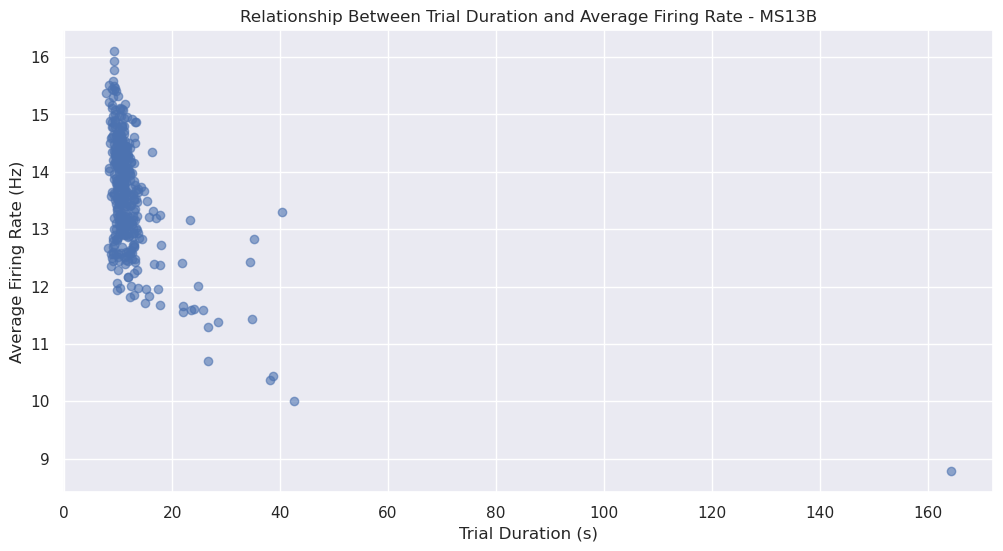

In [16]:
# Let's examine if there's a relationship between neural activity and trial durations
# For each trial, we'll calculate the average firing rate across all units

# First, let's define a function to get the firing rates during each trial
def get_trial_firing_rates(nwb_file, trial_df):
    trial_rates = []
    
    # Loop through each trial
    for _, trial in trial_df.iterrows():
        start_time = trial['start_time']
        stop_time = trial['stop_time']
        duration = stop_time - start_time
        
        # Count spikes for each unit in this trial
        trial_spikes = []
        for i in range(len(nwb_file.units)):
            spike_times = nwb_file.units['spike_times'][i]
            # Get spikes that occurred during this trial
            trial_mask = (spike_times >= start_time) & (spike_times <= stop_time)
            spikes_in_trial = sum(trial_mask)
            # Calculate firing rate for this unit in this trial
            rate = spikes_in_trial / duration
            trial_spikes.append(rate)
        
        # Average firing rate across all units for this trial
        avg_rate = np.mean(trial_spikes)
        trial_rates.append(avg_rate)
    
    return trial_rates

# Calculate average firing rates for each trial in the first subject
trial_rates_1 = get_trial_firing_rates(nwb, trials_1)
trials_1['avg_firing_rate'] = trial_rates_1

# Plot the relationship between trial duration and average firing rate
plt.figure(figsize=(12, 6))
plt.scatter(trials_1['duration'], trials_1['avg_firing_rate'], alpha=0.6)
plt.title('Relationship Between Trial Duration and Average Firing Rate - MS13B')
plt.xlabel('Trial Duration (s)')
plt.ylabel('Average Firing Rate (Hz)')
plt.grid(True)

## Conclusion

In this notebook, we've explored Dandiset 001375, which contains neural recordings from mice with DREADDs targeting GABAergic neurons in the medial septum. The recordings were taken while the mice were running laps in a virtual hallway.

We've examined:
- The structure and contents of the dataset
- Electrode configurations and recording locations
- Properties of the recorded neurons
- Trial structure and behavioral patterns
- Neural responses to trial events
- Raw neural data characteristics
- Comparisons between different subjects and recording sessions

This dataset provides a rich resource for studying how septal GABAergic activity affects hippocampal and neocortical function. Further analysis could include:
- More detailed examination of specific neuron types
- Analysis of oscillatory activity (theta, gamma)
- Correlation of neural activity with specific behavioral variables
- Comparisons between control and DREADD activation conditions
- Investigation of spatial coding properties

## Closing Resources

In [17]:
# Close the open NWB files
h5_file.close()
h5_file_2.close()